Found 110 patient sub-folders.

 Inspecting Valid Folder: TCGA_CS_4941_19960909
Image File: TCGA_CS_4941_19960909_10.tif
Mask File:  TCGA_CS_4941_19960909_10_mask.tif

 Data Properties
Image Shape: (256, 256, 3) (H, W, C)
Image Range: [0, 241] (Type: uint8)
Mask Shape:  (256, 256) (H, W)
Mask Range:  [0, 0] (Type: uint8)
Unique Mask Values: [0]


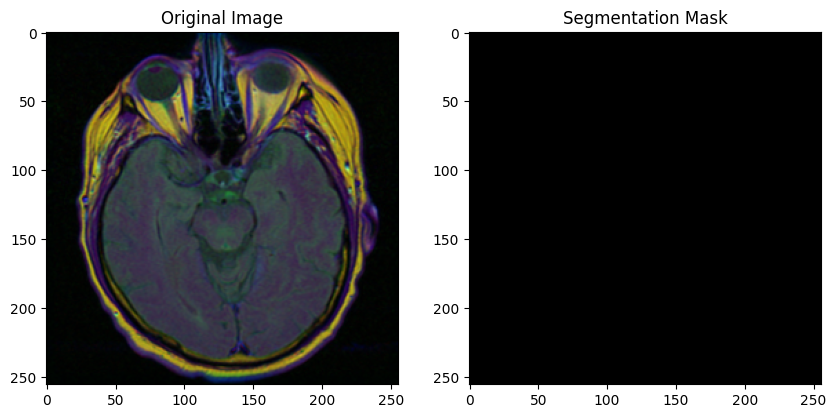

In [16]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

DATA_DIR = "./lgg-mri-segmentation/kaggle_3m"

def inspect_data():
    all_entries = glob.glob(os.path.join(DATA_DIR, "*"))
    patient_folders = [p for p in all_entries if os.path.isdir(p)]
    print(f"Found {len(patient_folders)} patient sub-folders.")
    
    found_valid_data = False
    for folder in patient_folders:
        mask_files = glob.glob(os.path.join(folder, "*_mask.tif"))
        
        if len(mask_files) > 0:
            print(f"\n Inspecting Valid Folder: {os.path.basename(folder)}")
            mask_path = mask_files[0]
            image_path = mask_path.replace("_mask.tif", ".tif")
            
            if os.path.exists(image_path):
                found_valid_data = True

                img = np.array(Image.open(image_path))
                mask = np.array(Image.open(mask_path))
                
                print(f"Image File: {os.path.basename(image_path)}")
                print(f"Mask File:  {os.path.basename(mask_path)}")
                
                print(f"\n Data Properties")
                print(f"Image Shape: {img.shape} (H, W, C)")
                print(f"Image Range: [{img.min()}, {img.max()}] (Type: {img.dtype})")
                print(f"Mask Shape:  {mask.shape} (H, W)")
                print(f"Mask Range:  [{mask.min()}, {mask.max()}] (Type: {mask.dtype})")
                print(f"Unique Mask Values: {np.unique(mask)}")
                
                # Visualization
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1); plt.title("Original Image"); plt.imshow(img)
                plt.subplot(1, 2, 2); plt.title("Segmentation Mask"); plt.imshow(mask, cmap='gray')
                plt.show()
            
                break
    
    if not found_valid_data:
        print("ERROR")

if __name__ == "__main__":
    inspect_data()

In [17]:
import torch
from torchvision import transforms

DATA_DIR = "./lgg-mri-segmentation/kaggle_3m"

def inspect_tumor_data():
    mask_files = glob.glob(os.path.join(DATA_DIR, "*/*_mask.tif"))
    found_tumor = False
    
    for mask_path in mask_files:
        mask = np.array(Image.open(mask_path))
        if mask.max() > 0:
            found_tumor = True
            image_path = mask_path.replace("_mask.tif", ".tif")
            
            print("\n TUMOR SAMPLE FOUND")
            print(f"Image File: {os.path.basename(image_path)}")
            print(f"Mask File:  {os.path.basename(mask_path)}")
            img = np.array(Image.open(image_path))
            
            print("\n Value Analysis ")
            print(f"Image Shape: {img.shape}")
            print(f"Image Range: Min={img.min()}, Max={img.max()} (Type: {img.dtype})")
            
            print(f"Mask Shape:  {mask.shape}")
            print(f"Mask Range:  Min={mask.min()}, Max={mask.max()} (Type: {mask.dtype})")
            print(f"Unique Mask Values: {np.unique(mask)}")
            t_transform = transforms.ToTensor()
            mask_tensor = t_transform(Image.open(mask_path))
            print(f"Tensor Max Value: {mask_tensor.max().item():.4f}")
            
            if mask_tensor.max().item() > 0.5:
                print("Mask uses 0 and 255. Standard ToTensor() works.")
            else:
                print("Mask uses 0 and 1. Need manual scaling!")
                
            break
            
    if not found_tumor:
        print("NO tumors")

if __name__ == "__main__":
    inspect_tumor_data()


 TUMOR SAMPLE FOUND
Image File: TCGA_CS_4941_19960909_11.tif
Mask File:  TCGA_CS_4941_19960909_11_mask.tif

 Value Analysis 
Image Shape: (256, 256, 3)
Image Range: Min=0, Max=248 (Type: uint8)
Mask Shape:  (256, 256)
Mask Range:  Min=0, Max=255 (Type: uint8)
Unique Mask Values: [  0 255]
Tensor Max Value: 1.0000
Mask uses 0 and 255. Standard ToTensor() works.


file_name TCGA_CS_4941_19960909_11.tif


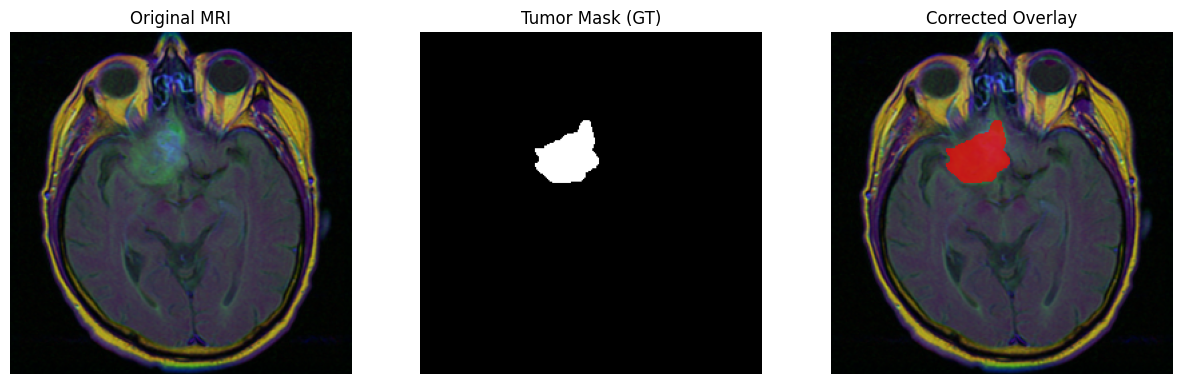

In [18]:
DATA_DIR = "./lgg-mri-segmentation/kaggle_3m"

def view_tumor_overlay_fixed():
    mask_files = glob.glob(os.path.join(DATA_DIR, "*/*_mask.tif"))
    
    for mask_path in mask_files:
        mask = np.array(Image.open(mask_path))
        
        if mask.max() > 0:
            image_path = mask_path.replace("_mask.tif", ".tif")
            if not os.path.exists(image_path): continue
                
            img = np.array(Image.open(image_path))
            overlay = img.copy()
            red_color = np.array([255, 0, 0], dtype=np.uint8)

            tumor_pixels = (mask > 0)
            overlay[tumor_pixels] = (0.7 * red_color + 0.3 * img[tumor_pixels]).astype(np.uint8)

            print(f"file_name {os.path.basename(image_path)}")

            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.title("Original MRI")
            plt.imshow(img)
            plt.axis('off')
            
            plt.subplot(1, 3, 2)
            plt.title("Tumor Mask (GT)")
            plt.imshow(mask, cmap='gray')
            plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.title("Corrected Overlay")
            plt.imshow(overlay)
            plt.axis('off')
            
            plt.show()
            break

if __name__ == "__main__":
    view_tumor_overlay_fixed()

In [19]:
import os
import time
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import deepinv as dinv
import kornia
import matplotlib.pyplot as plt

In [20]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "./lgg-mri-segmentation/kaggle_3m"
IMG_SIZE = 128
ACCELERATION = 2 # 2 works the best

SUBSET_SIZE = None     
PRETRAIN_EPOCHS = 50   
HOAG_ITERS = 30        
HOAG_INNER_STEPS = 50 
THETA_INIT = torch.tensor([-3.0, -4.0]) 

print(f"Running on: {DEVICE}")

Running on: cuda


In [21]:
def robust_normalize(x):
    b = x.shape[0]
    x_flat = x.view(b, -1)
    val_min = torch.quantile(x_flat, 0.01, dim=1).view(b, 1, 1, 1)
    val_max = torch.quantile(x_flat, 0.98, dim=1).view(b, 1, 1, 1)
    x = torch.clamp(x, val_min, val_max)
    return (x - val_min) / (val_max - val_min + 1e-8)

def calculate_dice(pred_mask, target_mask, threshold=0.5):
    if torch.isnan(pred_mask).any(): return 0.0
    pred_binary = (pred_mask > threshold).float()
    intersection = (pred_binary * target_mask).sum()
    union = pred_binary.sum() + target_mask.sum()
    if union == 0: return 1.0
    dice = (2. * intersection) / (union + 1e-8)
    return dice.item()

In [22]:
# Dataset
class LGGMRIDataset(Dataset):
    def __init__(self, root_dir, subset_size=None, augment=False):
        self.root_dir = root_dir
        self.augment = augment
        all_mask_paths = sorted(glob.glob(os.path.join(root_dir, "*/*_mask.tif")))
        all_image_paths = [p.replace("_mask.tif", ".tif") for p in all_mask_paths]
        
        valid_pairs = []
        #print(f"Scanning files (Augment={'On' if augment else 'Off'})...")
        for img, mask in zip(all_image_paths, all_mask_paths):
            if os.path.exists(img):
                if np.array(Image.open(mask)).max() > 0: 
                    valid_pairs.append((img, mask))
            if subset_size and len(valid_pairs) >= subset_size: break
        
        self.image_paths, self.mask_paths = zip(*valid_pairs)
        print(f"Dataset loaded: {len(valid_pairs)} POSITIVE pairs.")

        self.resize = transforms.Resize((IMG_SIZE, IMG_SIZE))
        self.to_tensor = transforms.ToTensor()

    def __len__(self): return len(self.image_paths)

    def __getitem__(self, idx):
        img = self.resize(Image.open(self.image_paths[idx]))
        mask = self.resize(Image.open(self.mask_paths[idx]))
        if self.augment:
            if torch.rand(1) > 0.5:
                img = transforms.functional.hflip(img)
                mask = transforms.functional.hflip(mask)
            if torch.rand(1) > 0.5:
                img = transforms.functional.vflip(img)
                mask = transforms.functional.vflip(mask)
            if torch.rand(1) > 0.5:
                angle = np.random.randint(-15, 15)
                img = transforms.functional.rotate(img, angle)
                mask = transforms.functional.rotate(mask, angle)

        img_t = self.to_tensor(img)
        mask_t = self.to_tensor(mask)
        if img_t.shape[0] == 3: img_t = img_t[1:2, :, :] 
        return img_t, mask_t

In [23]:
# Model and loss function 
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(),
                nn.Conv2d(out_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU()
            )
        self.enc1 = block(1, 32); self.pool = nn.MaxPool2d(2)
        self.enc2 = block(32, 64)
        self.enc3 = block(64, 128)
        self.bottleneck = block(128, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = block(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = block(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = block(64, 32)
        self.final = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))
        d3 = self.dec3(torch.cat([self.up3(b), e3], 1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], 1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], 1)) 
        return torch.sigmoid(self.final(d1))

class ComboLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()
    def forward(self, pred, target):
        smooth = 1.0
        intersection = (pred * target).sum(dim=(2,3))
        dice_loss = 1 - ((2. * intersection + smooth) / 
                         (pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) + smooth))
        # Weighted Loss: 10% BCE + 90% Dice
        return 0.1 * self.bce(pred, target) + 0.9 * dice_loss.mean()


In [24]:
mask = torch.zeros((1, IMG_SIZE, IMG_SIZE))
center_fraction = 0.08
num_cols = IMG_SIZE
num_low_freqs = int(round(num_cols * center_fraction))
pad = (num_cols - num_low_freqs + 1) // 2
mask[:, :, pad:pad + num_low_freqs] = 1.0
num_keep = int(num_cols / ACCELERATION)
all_cols = np.arange(num_cols)
kept_cols = np.where(mask[0, 0, :].numpy() == 1)[0]
zero_cols = np.setdiff1d(all_cols, kept_cols)
if len(zero_cols) > 0:
    chosen = np.random.choice(zero_cols, num_keep - len(kept_cols), replace=False)
    mask[:, :, chosen] = 1.0
mask = mask.to(DEVICE)
physics = dinv.physics.MRI(mask=mask, img_size=(1, IMG_SIZE, IMG_SIZE), device=DEVICE)

def total_variation(x, theta):
    scale = torch.exp(theta[0])
    eps = torch.exp(theta[1])**2 + 1e-8
    grad = kornia.filters.spatial_gradient(x, mode='diff') 
    tv = torch.sum(torch.sqrt(grad[:,:,0]**2 + grad[:,:,1]**2 + eps))
    return scale * tv

def inner_loss_func(x_recon, theta, y_kspace):
    y_pred = physics(x_recon) 
    fidelity = 0.5 * torch.norm(y_kspace - y_pred)**2
    reg = total_variation(x_recon, theta)
    return fidelity + reg

In [25]:
# visualization
def save_results_grid(results, filename="final_results_grid.png"):
    results.sort(key=lambda x: x['dice'], reverse=True)
    to_plot = results[:3] + results[-3:]
    
    plt.figure(figsize=(12, 10))
    plt.suptitle("Top 3 Best (Top) vs Bottom 3 Worst (Bottom)", fontsize=16)
    
    for i, res in enumerate(to_plot):
        plt.subplot(6, 3, i*3 + 1)
        plt.imshow(res['recon'], cmap='gray')
        plt.title(f"Recon (Dice: {res['dice']:.2f})"); plt.axis('off')
        
        plt.subplot(6, 3, i*3 + 2)
        plt.imshow(res['gt'], cmap='gray')
        plt.title("Ground Truth"); plt.axis('off')
        
        plt.subplot(6, 3, i*3 + 3)
        plt.imshow(res['pred'], cmap='gray')
        plt.title("Prediction"); plt.axis('off')
        
    plt.tight_layout()
    plt.savefig(filename)
    
    print(f"Saved report grid to '{filename}'")



 Loading Data 
Dataset loaded: 1373 POSITIVE pairs.
  [Epoch 10] Train Dice: 0.7935 | LR: 0.001000
  [Epoch 20] Train Dice: 0.8424 | LR: 0.001000
  [Epoch 30] Train Dice: 0.8567 | LR: 0.001000
  [Epoch 40] Train Dice: 0.8811 | LR: 0.001000
  [Epoch 50] Train Dice: 0.8970 | LR: 0.001000

 HOAG Optimization
  [HOAG 5] Loss: 0.3016 | Dice: 0.6835 | Scale: 0.0481
  [HOAG 10] Loss: 0.0843 | Dice: 0.9082 | Scale: 0.0468
  [HOAG 15] Loss: 0.7267 | Dice: 0.2037 | Scale: 0.0460
  [HOAG 20] Loss: 0.0535 | Dice: 0.9443 | Scale: 0.0464
  [HOAG 25] Loss: 0.3642 | Dice: 0.6114 | Scale: 0.0463
  [HOAG 30] Loss: 0.1009 | Dice: 0.8974 | Scale: 0.0458
FINAL AVERAGE DICE: 0.7757
Saved report grid to 'final_results_grid.png'


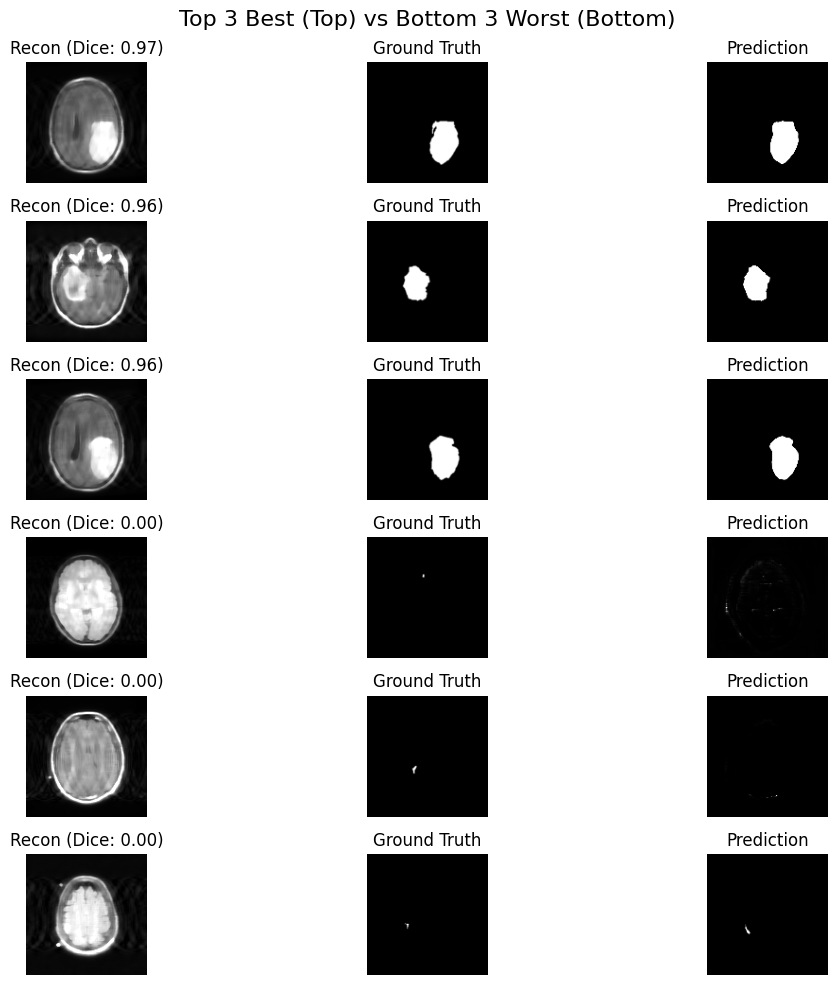

In [26]:
# Main pipeline
def main():
    print("\n Loading Data ")
    full_ds = LGGMRIDataset(DATA_DIR, subset_size=SUBSET_SIZE, augment=True)
    train_size = int(0.8 * len(full_ds))
    val_size = len(full_ds) - train_size
    train_ds, val_ds = torch.utils.data.random_split(full_ds, [train_size, val_size])
    val_ds.dataset.augment = False
    
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=True) 

    # Pretraining
    unet = UNet().to(DEVICE)
    optim_u = torch.optim.Adam(unet.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_u, 'max', patience=5, factor=0.5)
    loss_fn = ComboLoss()
    
    for epoch in range(PRETRAIN_EPOCHS):
        unet.train()
        epoch_dice = 0
        for img, mask_gt in train_loader:
            img, mask_gt = img.to(DEVICE), mask_gt.to(DEVICE)
            mask_gt = mask_gt.clamp(0.0, 1.0)
            
            with torch.no_grad():
                x_gt_2ch = torch.cat([img, torch.zeros_like(img)], dim=1)
                y_kspace = physics(x_gt_2ch)
                x_zf = physics.A_adjoint(y_kspace)
                x_input = torch.sqrt(x_zf[:,0:1]**2 + x_zf[:,1:2]**2 + 1e-8)
                x_input = robust_normalize(x_input)
                
                if torch.rand(1) < 0.3:
                    x_input = kornia.filters.gaussian_blur2d(x_input, (3,3), (0.5, 0.5))
            
            optim_u.zero_grad()
            pred = unet(x_input).clamp(1e-6, 1-1e-6)
            loss = loss_fn(pred, mask_gt)
            loss.backward()
            optim_u.step()
            epoch_dice += calculate_dice(pred, mask_gt)
        
        avg_dice = epoch_dice/len(train_loader)
        scheduler.step(avg_dice)
        if (epoch+1) % 10 == 0:
            print(f"  [Epoch {epoch+1}] Train Dice: {avg_dice:.4f} | LR: {optim_u.param_groups[0]['lr']:.6f}")

    # Hoag
    print("\n HOAG Optimization")
    unet.eval()
    for p in unet.parameters(): p.requires_grad = False
    
    theta = THETA_INIT.clone().to(DEVICE).requires_grad_(True)
    hoag_optim = torch.optim.Adam([theta], lr=0.01)
    hoag_iter_loader = DataLoader(val_ds, batch_size=1, shuffle=True)
    val_iter = iter(hoag_iter_loader)
    
    for k in range(HOAG_ITERS):
        try: x_gt, mask_gt = next(val_iter)
        except StopIteration:
            val_iter = iter(hoag_iter_loader); x_gt, mask_gt = next(val_iter)
        
        x_gt = x_gt.to(DEVICE); mask_gt = mask_gt.to(DEVICE).clamp(0.0, 1.0)
        x_gt_2ch = torch.cat([x_gt, torch.zeros_like(x_gt)], dim=1)
        y_kspace = physics(x_gt_2ch)
        x_zf = physics.A_adjoint(y_kspace)
        w = x_zf.detach().clone().requires_grad_(True)
        
        nan_flag = False
        for _ in range(HOAG_INNER_STEPS):
            loss = inner_loss_func(w, theta, y_kspace)
            gw = autograd.grad(loss, w, create_graph=True)[0]
            if torch.isnan(gw).any(): nan_flag=True; break
            w = w - 0.05 * gw 
        if nan_flag: continue
        
        w_mag = torch.sqrt(w[:,0:1]**2 + w[:,1:2]**2 + 1e-8)
        w_mag = robust_normalize(w_mag)
        pred = unet(w_mag).clamp(1e-6, 1-1e-6)
        outer_loss = loss_fn(pred, mask_gt)
        dice = calculate_dice(pred, mask_gt)
        
        hoag_optim.zero_grad()
        outer_loss.backward()
        torch.nn.utils.clip_grad_norm_([theta], 1.0)
        hoag_optim.step()
        
        with torch.no_grad():
             theta[0].clamp_(-5.0, 0.0) 
             theta[1].clamp_(-12, -2)
        
        if (k+1) % 5 == 0:
            print(f"  [HOAG {k+1}] Loss: {outer_loss.item():.4f} | Dice: {dice:.4f} | Scale: {torch.exp(theta[0]):.4f}")

    # Final Eval
    eval_loader = DataLoader(val_ds, batch_size=1, shuffle=False)
    unet.eval()
    total_dice = 0; count = 0
    theta_final = theta.detach()
    all_results = []
    
    for i, (x_gt, mask_gt) in enumerate(eval_loader):
        x_gt = x_gt.to(DEVICE); mask_gt = mask_gt.to(DEVICE).clamp(0.0, 1.0)
        x_gt_2ch = torch.cat([x_gt, torch.zeros_like(x_gt)], dim=1)
        y_kspace = physics(x_gt_2ch)
        x_zf = physics.A_adjoint(y_kspace)
        w = x_zf.clone().detach().requires_grad_(True)
        
        for _ in range(HOAG_INNER_STEPS): 
            loss = inner_loss_func(w, theta_final, y_kspace)
            gw = autograd.grad(loss, w)[0]
            w = w - 0.05 * gw
            w = w.detach().requires_grad_(True)
            
        with torch.no_grad():
            w_mag = torch.sqrt(w[:,0:1]**2 + w[:,1:2]**2 + 1e-8)
            w_mag = robust_normalize(w_mag)
            pred = unet(w_mag)
            dice = calculate_dice(pred, mask_gt)
            total_dice += dice; count += 1
            all_results.append({'dice': dice, 'recon': w_mag[0,0].cpu().numpy(), 'gt': mask_gt[0,0].cpu().numpy(), 'pred': pred[0,0].cpu().numpy()})

    print("="*40)
    print(f"FINAL AVERAGE DICE: {total_dice/count:.4f}")
    print("="*40)
    save_results_grid(all_results, "final_results_grid.png")

if __name__ == "__main__":
    main()